In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sqlalchemy import create_engine
import pandas as pd
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [3]:
url ="https://raw.githubusercontent.com/danmeor/CunPrueba/main/data1.csv"
url1 ="https://raw.githubusercontent.com/danmeor/CunPrueba/main/sales_predictions_simulado.csv"
# Lee el archivo CSV desde la URL
df = pd.read_csv(url)
df1 = pd.read_csv(url1)

print(df1)

       id        date  product_id  store_id  sales     category
0       2  2025-04-23         102         3     38     paraguas
1       3  2025-05-05         103         1     62     chaqueta
2       6  2025-05-14         102         2     45     paraguas
3       7  2025-04-21         101         3     43  impermeable
4       8  2025-03-24         102         1     64     paraguas
..    ...         ...         ...       ...    ...          ...
407   994  2025-03-28         102         3     44     paraguas
408   995  2025-05-19         101         2     51  impermeable
409   996  2025-05-26         102         3     36     paraguas
410   999  2025-04-07         103         2     39     chaqueta
411  1000  2025-03-31         102         2     50     paraguas

[412 rows x 6 columns]


In [4]:
df2= df.merge(df1,how="left",on='store_id')
df2

,store_id,name,city,latitude,longitude,id,date,product_id,sales,category
0,1,Tienda Bogotá Centro,Bogotá,4.6097,-74.0817,3,2025-05-05,103,62,chaqueta
1,1,Tienda Bogotá Centro,Bogotá,4.6097,-74.0817,8,2025-03-24,102,64,paraguas
2,1,Tienda Bogotá Centro,Bogotá,4.6097,-74.0817,18,2025-04-23,101,73,impermeable
3,1,Tienda Bogotá Centro,Bogotá,4.6097,-74.0817,20,2025-03-16,102,66,paraguas
4,1,Tienda Bogotá Centro,Bogotá,4.6097,-74.0817,21,2025-05-16,102,59,paraguas
...,...,...,...,...,...,...,...,...,...,...
407,3,Tienda Cali Norte,Cali,3.4516,-76.5320,957,2025-05-08,102,40,paraguas
408,3,Tienda Cali Norte,Cali,3.4516,-76.5320,972,2025-05-19,103,48,chaqueta
409,3,Tienda Cali Norte,Cali,3.4516,-76.5320,973,2025-05-20,102,39,paraguas
410,3,Tienda Cali Norte,Cali,3.4516,-76.5320,994,2025-03-28,102,44,paraguas


In [5]:
df2.drop(columns=['name'],inplace=True)
df2

,store_id,city,latitude,longitude,id,date,product_id,sales,category
0,1,Bogotá,4.6097,-74.0817,3,2025-05-05,103,62,chaqueta
1,1,Bogotá,4.6097,-74.0817,8,2025-03-24,102,64,paraguas
2,1,Bogotá,4.6097,-74.0817,18,2025-04-23,101,73,impermeable
3,1,Bogotá,4.6097,-74.0817,20,2025-03-16,102,66,paraguas
4,1,Bogotá,4.6097,-74.0817,21,2025-05-16,102,59,paraguas
...,...,...,...,...,...,...,...,...,...
407,3,Cali,3.4516,-76.5320,957,2025-05-08,102,40,paraguas
408,3,Cali,3.4516,-76.5320,972,2025-05-19,103,48,chaqueta
409,3,Cali,3.4516,-76.5320,973,2025-05-20,102,39,paraguas
410,3,Cali,3.4516,-76.5320,994,2025-03-28,102,44,paraguas


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   store_id    412 non-null    int64  
 1   city        412 non-null    object 
 2   latitude    412 non-null    float64
 3   longitude   412 non-null    float64
 4   id          412 non-null    int64  
 5   date        412 non-null    object 
 6   product_id  412 non-null    int64  
 7   sales       412 non-null    int64  
 8   category    412 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 29.1+ KB


In [7]:
print(df2.isnull().sum())

store_id      0
city          0
latitude      0
longitude     0
id            0
date          0
product_id    0
sales         0
category      0
dtype: int64


In [8]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

df3 = pd.DataFrame([])
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
for i in df2['id'].unique():
	cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
	retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
	openmeteo = openmeteo_requests.Client(session = retry_session)

	params = {
		"latitude": df2.loc[df2['id']==i,'latitude'].values[0],
		"longitude": df2.loc[df2['id']==i,'longitude'].values[0],
		"daily": ["temperature_2m_max", "temperature_2m_min"],
		"timezone": "auto",
		"start_date": df2.loc[df2['id']==i,'date'].values[0],
		"end_date": df2.loc[df2['id']==i,'date'].values[0]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]


	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
	daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()

	daily_data = {"date": pd.date_range(
		start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
		end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = daily.Interval()),
		inclusive = "left"
	)}

	daily_data["temperature_2m_max"] = daily_temperature_2m_max
	daily_data["temperature_2m_min"] = daily_temperature_2m_min
	daily_data["average_temperature"] =(daily_data["temperature_2m_max"] + daily_data["temperature_2m_min"])/ 2
	
	daily_dataframe = pd.DataFrame(data = daily_data)
	daily_dataframe['id'] = i
	
	df3 = pd.concat([df3,daily_dataframe])

In [9]:
df3['date']=df3['date'].dt.date
df3.reset_index(drop=True, inplace=True)

In [10]:
df3

,date,temperature_2m_max,temperature_2m_min,average_temperature,id
0,2025-05-05,16.768000,11.868000,14.318000,3
1,2025-03-24,19.650000,9.050000,14.350000,8
2,2025-04-23,16.718000,9.418000,13.068001,18
3,2025-03-16,18.750000,7.750000,13.250000,20
4,2025-05-16,18.468000,11.618000,15.043000,21
...,...,...,...,...,...
407,2025-05-08,26.503000,18.853001,22.678001,957
408,2025-05-19,25.953001,18.803001,22.378002,972
409,2025-05-20,27.353001,19.503000,23.428001,973
410,2025-03-28,26.220001,18.020000,22.120001,994


In [11]:
salesp  =  df2.merge(df3[['id','average_temperature']],how='left',on=['id'])
salesp 

,store_id,city,latitude,longitude,id,date,product_id,sales,category,average_temperature
0,1,Bogotá,4.6097,-74.0817,3,2025-05-05,103,62,chaqueta,14.318000
1,1,Bogotá,4.6097,-74.0817,8,2025-03-24,102,64,paraguas,14.350000
2,1,Bogotá,4.6097,-74.0817,18,2025-04-23,101,73,impermeable,13.068001
3,1,Bogotá,4.6097,-74.0817,20,2025-03-16,102,66,paraguas,13.250000
4,1,Bogotá,4.6097,-74.0817,21,2025-05-16,102,59,paraguas,15.043000
...,...,...,...,...,...,...,...,...,...,...
407,3,Cali,3.4516,-76.5320,957,2025-05-08,102,40,paraguas,22.678001
408,3,Cali,3.4516,-76.5320,972,2025-05-19,103,48,chaqueta,22.378002
409,3,Cali,3.4516,-76.5320,973,2025-05-20,102,39,paraguas,23.428001
410,3,Cali,3.4516,-76.5320,994,2025-03-28,102,44,paraguas,22.120001


In [ ]:
salesp['date'] = pd.to_datetime(salesp['date'])
salesp['date'] = salesp['date'] .astype('int64')

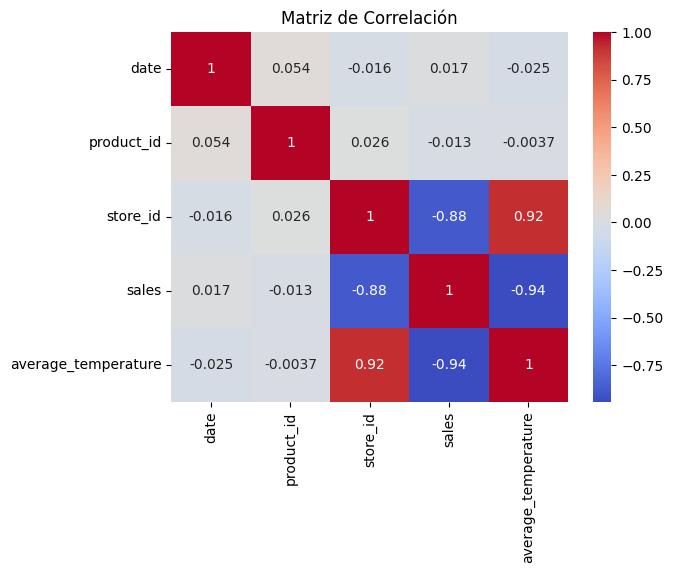

In [13]:
matriz_correlacion = salesp[['date','product_id','store_id','sales','average_temperature']].corr()
sns.heatmap(matriz_correlacion,annot=True,cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


In [14]:
x=salesp['average_temperature'].values.reshape(-1,1)
y=salesp["sales"].values.reshape(-1,1)
sc_x = StandardScaler()
sc_y = StandardScaler()
x_std = sc_x.fit_transform(x)
y_std = sc_y.fit_transform(y)
slr = LinearRegression()
slr.fit(x_std,y_std)

LinearRegression()

Text(0.5, 0, 'Temperatura')

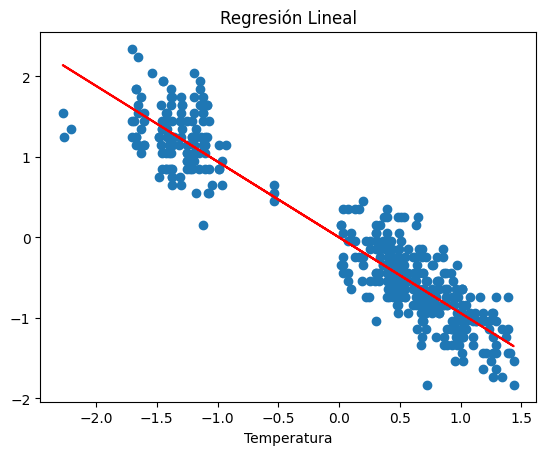

In [22]:
plt.scatter(x_std,y_std)
plt.plot(x_std,slr.predict(x_std),color="Red")
plt.title("Regresión Lineal")
plt.xlabel("Temperatura")

In [16]:
reg_L = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
reg_L.fit(X_train, y_train)
y_pred = reg_L.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R^2):{r2}")

Error cuadrático medio (MSE): 9.551983833312988
Coeficiente de determinación (R^2):0.900353729724884


In [17]:
salesp['date'] = pd.to_datetime(salesp['date'], unit='ns')

In [18]:
salesp["sales_prediction"] = reg_L.predict(salesp["average_temperature"].values.reshape(-1, 1))
salesp


,store_id,city,latitude,longitude,id,date,product_id,sales,category,average_temperature,sales_prediction
0,1,Bogotá,4.6097,-74.0817,3,2025-05-05,103,62,chaqueta,14.318000,62.290947
1,1,Bogotá,4.6097,-74.0817,8,2025-03-24,102,64,paraguas,14.350000,62.213772
2,1,Bogotá,4.6097,-74.0817,18,2025-04-23,101,73,impermeable,13.068001,65.305595
3,1,Bogotá,4.6097,-74.0817,20,2025-03-16,102,66,paraguas,13.250000,64.866669
4,1,Bogotá,4.6097,-74.0817,21,2025-05-16,102,59,paraguas,15.043000,60.542450
...,...,...,...,...,...,...,...,...,...,...,...
407,3,Cali,3.4516,-76.5320,957,2025-05-08,102,40,paraguas,22.678001,42.128952
408,3,Cali,3.4516,-76.5320,972,2025-05-19,103,48,chaqueta,22.378002,42.852467
409,3,Cali,3.4516,-76.5320,973,2025-05-20,102,39,paraguas,23.428001,40.320160
410,3,Cali,3.4516,-76.5320,994,2025-03-28,102,44,paraguas,22.120001,43.474693


In [19]:
usuario = 'postgres'
contrasena = "Danmeor2010"
host = 'localhost'
puerto = '5432'
base_datos = 'postgres'
conexion = create_engine(f'postgresql+psycopg2://{usuario}:{contrasena}@{host}:{puerto}/{base_datos}')
salesp.to_sql('sales_prediction', conexion, if_exists='replace', index=False)

412

02:33:05 - cmdstanpy - INFO - Chain [1] start processing
02:33:05 - cmdstanpy - INFO - Chain [1] done processing


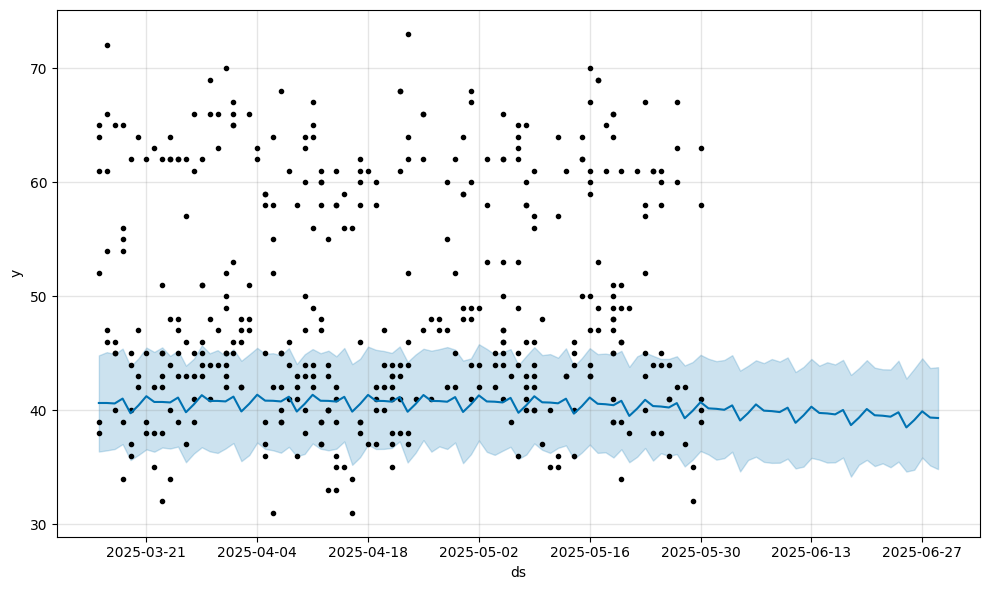

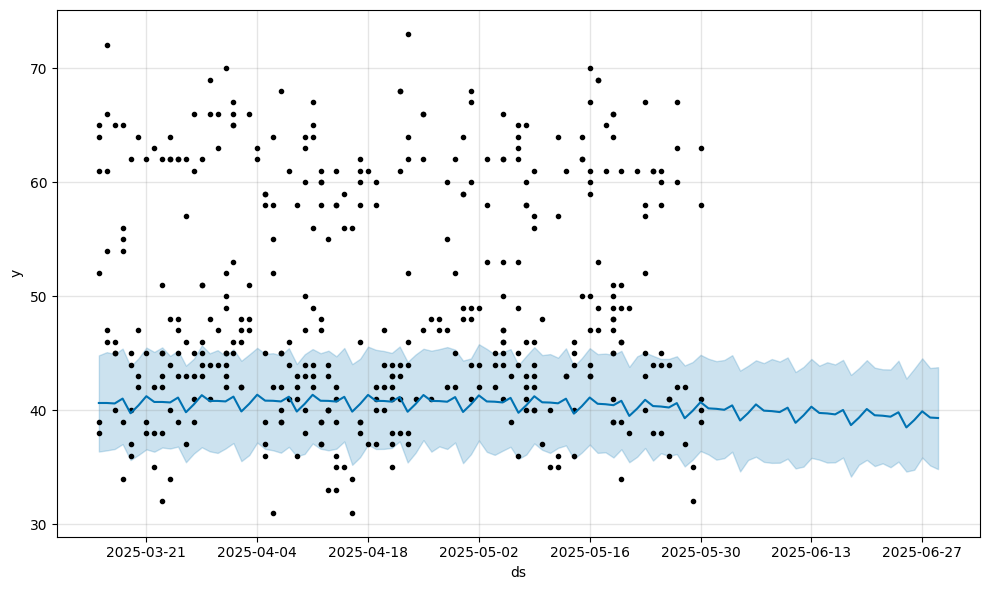

In [ ]:
# Renombrar las columnas para que Prophet las reconozca
salesp.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Inicializar el modelo y entrenarlo
model = Prophet()       

# Puedes agregar factores externos (regresores) si crees que afectan las ventas
model.add_regressor('store_id')
model.add_regressor('average_temperature')

# Ajustar el modelo con los datos
model.fit(salesp)

# Generar predicciones futuras
future = model.make_future_dataframe(periods=30)  # 30 días futuros

# Asegurar que las variables externas estén presentes en el dataframe futuro
future['store_id'] = salesp['store_id'].iloc[-1]  # Puedes mejorar esto con estimaciones
future['average_temperature'] = salesp['average_temperature'].iloc[-1]

# Obtener las predicciones
forecast = model.predict(future)

# Visualizar los resultados
model.plot(forecast)

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Comparar las predicciones con los valores reales
y_true = salesp['y'][-30:]  # Últimos 30 días reales
y_pred = forecast['yhat'][-30:]  # Últimos 30 días predichos

# Calcular métricas de error
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Calcular RMSE manualmente

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 3.4936307684192154
RMSE: 4.298559914024263
